In [105]:
# === Step 1: Environment & API Initialization ===
# Load environment variables, set up OpenAI API key, and validate critical configurations

import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import logging
from dotenv import load_dotenv
import openai

# --- Configure Logging ---
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")

# --- Load .env file ---
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")

# --- Function to Validate and Set OpenAI API Key ---
def initialize_openai():
    if not api_key:
        raise EnvironmentError("OPENAI_API_KEY not found in .env file.")
    openai.api_key = api_key
    logging.info("OpenAI API key loaded and initialized.")

# --- Call Initialization ---
initialize_openai()

2025-05-30 00:09:54,790 [INFO] OpenAI API key loaded and initialized.


Sample engagement data (simulated with noise):


,hour,sessions,is_weekend,time
0,0,47,False,00:00:00
1,1,34,False,01:00:00
2,2,36,False,02:00:00
3,3,24,False,03:00:00
4,4,24,False,04:00:00


Peak Hour: 18:00
Average Sessions per Hour: 91.92


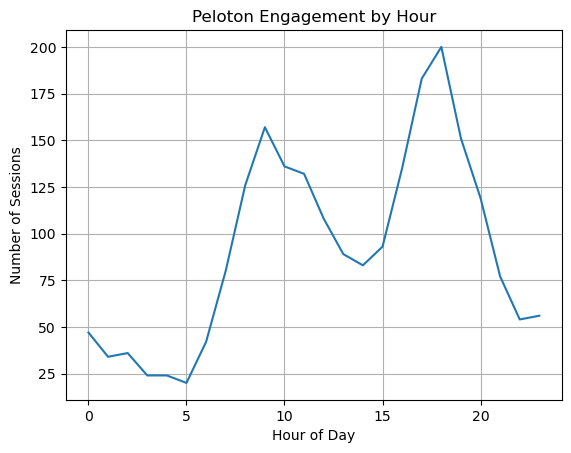

In [107]:
# Step 2: Simulate realistic engagement data for a single day

import numpy as np

# Simulate hourly engagement with variability (base pattern + noise)
base_sessions = np.array([
    50, 40, 35, 30, 25, 20, 45, 80, 120, 160, 140, 130,
    110, 90, 85, 100, 140, 180, 200, 150, 120, 80, 60, 40
])
noise = np.random.normal(loc=0, scale=5, size=24).astype(int)
sessions_with_noise = np.clip(base_sessions + noise, 0, None)  # No negative sessions

# Add simulated metadata
engagement_data = pd.DataFrame({
    'hour': list(range(24)),
    'sessions': sessions_with_noise,
    'is_weekend': False,  # Could toggle to True to simulate weekend behavior
})

# Convert hour to readable time
engagement_data['time'] = pd.to_datetime(engagement_data['hour'], format='%H').dt.time

# Display head
print("Sample engagement data (simulated with noise):")
display(engagement_data.head())

# Add summary statistics for agent use
peak_hour = engagement_data.loc[engagement_data['sessions'].idxmax(), 'hour']
avg_sessions = engagement_data['sessions'].mean()
print(f"Peak Hour: {peak_hour}:00")
print(f"Average Sessions per Hour: {avg_sessions:.2f}")

# Visualize
engagement_data.plot(x='hour', y='sessions', kind='line', title='Peloton Engagement by Hour', legend=False)
plt.xlabel("Hour of Day")
plt.ylabel("Number of Sessions")
plt.grid(True)
plt.show()

In [125]:
from openai import OpenAI
from typing import TypedDict, List, Dict, Any
from geopy.distance import geodesic
from datetime import datetime
from tqdm import tqdm
import time

# Define the state structure
class WorkoutState(TypedDict):
    agent_type: str
    goals: List[str]
    recent_workouts: List[str]
    output: str
    login_events: List[Dict[str, Any]]  # New: Include login events in the state

# Simple location lookup (real projects should use geocoding API)
LOCATION_COORDS = {
    "New York": (40.7128, -74.0060),
    "Paris": (48.8566, 2.3522),
    "San Francisco": (37.7749, -122.4194)
}

client = OpenAI()

def fraud_agent_node(state: WorkoutState) -> WorkoutState:
    login_events = state.get("login_events", [])

    if len(login_events) < 2:
        return {**state, "output": "Not enough login events to analyze travel patterns."}

    # Create login text and analyze travel distances
    login_text = ""
    for i in range(len(login_events)):
        e = login_events[i]
        login_text += f"Time: {e['timestamp']}, IP: {e['ip']}, Location: {e['location']}\n"

    travel_notes = []
    for i in tqdm(range(1, len(login_events)), desc="Analyzing login transitions..."):
        loc1 = login_events[i - 1]["location"]
        loc2 = login_events[i]["location"]
        time1 = datetime.fromisoformat(login_events[i - 1]["timestamp"].replace("Z", "+00:00"))
        time2 = datetime.fromisoformat(login_events[i]["timestamp"].replace("Z", "+00:00"))

        if loc1 in LOCATION_COORDS and loc2 in LOCATION_COORDS:
            distance_km = geodesic(LOCATION_COORDS[loc1], LOCATION_COORDS[loc2]).kilometers
            duration_hr = (time2 - time1).total_seconds() / 3600
            speed_kph = distance_km / duration_hr if duration_hr > 0 else float("inf")
            travel_notes.append(
                f"Travel from {loc1} to {loc2} covers {distance_km:.1f} km in {duration_hr:.2f} hours (~{speed_kph:.1f} km/h)."
            )
        else:
            travel_notes.append(f"Skipping distance calculation between {loc1} and {loc2} (location not found).")

        time.sleep(0.3)  # Simulate computation time for the loading bar

    full_prompt = (
        f"The following login events occurred:\n{login_text}\n"
        f"Travel observations:\n" + "\n".join(travel_notes) + "\n\n"
        "As a security AI, identify any suspicious travel patterns or anomalies that suggest fraud. "
        "Estimate a confidence score (0-100%) for whether this is fraudulent activity, and explain your reasoning."
    )

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "You are a cybersecurity assistant reviewing login activity for fraud detection."},
                {"role": "user", "content": full_prompt}
            ],
            temperature=0.3,
            max_tokens=350
        )
        result = response.choices[0].message.content
    except Exception as e:
        result = f"Error during fraud analysis: {str(e)}"

    return {**state, "output": result}

# Example test
test_input: WorkoutState = {
    "agent_type": "fraud",
    "goals": [],
    "recent_workouts": [],
    "output": "",
    "login_events": [
        {"timestamp": "2024-04-01T02:15:00Z", "ip": "192.168.1.1", "location": "New York"},
        {"timestamp": "2024-04-01T02:18:00Z", "ip": "203.0.113.5", "location": "Paris"},
        {"timestamp": "2024-04-01T08:20:00Z", "ip": "198.51.100.23", "location": "San Francisco"}
    ]
}

output_state = fraud_agent_node(test_input)
print("\nFraud Agent Output:\n")
print(output_state["output"])

Analyzing login transitions...: 100%|█████████████| 2/2 [00:00<00:00,  3.26it/s]
2025-05-30 00:21:05,492 [INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Fraud Agent Output:

Based on the login events and travel observations provided, there are clear indications of suspicious activity due to the implausible travel times and speeds between the locations. Let's analyze the details:

1. **Travel from New York to Paris:**
   - Distance: 5852.9 km
   - Time: 3 minutes (0.05 hours)
   - Speed: ~117,058.7 km/h

   This speed is far beyond the capabilities of any known commercial or private aircraft. The fastest commercial jets travel at speeds around 900-1,000 km/h. Therefore, this travel is impossible within the given timeframe.

2. **Travel from Paris to San Francisco:**
   - Distance: 8976.2 km
   - Time: 6.03 hours
   - Speed: ~1,487.8 km/h

   While this speed is closer to the realm of possibility, it still exceeds the speed of typical commercial flights. Supersonic travel could potentially achieve this speed, but such flights are not commercially available for these routes.

**Conclusion:**

The login events suggest that the user accoun

In [133]:
from typing import TypedDict, List
from openai import OpenAI
from tqdm import tqdm
import time

# Define state type
class WorkoutState(TypedDict):
    agent_type: str
    goals: List[str]
    recent_workouts: List[str]
    output: str

# Initialize OpenAI client
client = OpenAI()

# Product Recommendation Agent Node (Enhanced to recommend real Peloton classes)
def product_agent_node(state: WorkoutState) -> WorkoutState:
    goals = state.get("goals", [])
    recent_workouts = state.get("recent_workouts", [])

    if not goals or not recent_workouts:
        return {**state, "output": "Insufficient data for personalized recommendation."}

    # Create profile string
    profile_str = (
        "User Fitness Goals: " + ", ".join(goals) + "\n"
        "Recent Workouts: " + ", ".join(recent_workouts)
    )

    # Show loading bar
    for _ in tqdm(range(3), desc="Generating personalized Peloton workout..."):
        time.sleep(0.3)

    # Enhanced prompts for specificity
    system_prompt = (
        "You are a Peloton fitness assistant. Always recommend a real, specific Peloton workout class "
        "or program, including the class type (e.g., 'Power Zone Ride', 'HIIT Cardio', 'Full Body Bootcamp'), "
        "and if possible, suggest a real Peloton instructor. Make your answer motivating and explain your choice."
    )
    user_prompt = (
        f"Here is the user's profile:\n{profile_str}\n\n"
        "Recommend their next Peloton class, using real class names or types."
    )

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            temperature=0.4,
            max_tokens=350
        )
        result = response.choices[0].message.content
    except Exception as e:
        result = f"Error during recommendation: {str(e)}"

    return {**state, "output": result}

# --- Example Test Invocation ---
test_input: WorkoutState = {
    "agent_type": "product",
    "goals": ["muscle gain", "strength training"],
    "recent_workouts": ["Full Body Strength", "Upper Body Dumbbell Burn", "Core Conditioning"],
    "output": ""
}

output_state = product_agent_node(test_input)
print("\nProduct Agent Output:\n")
print(output_state["output"])

Generating personalized Peloton workout...: 100%|█| 3/3 [00:00<00:00,  3.29it/s]
2025-05-30 00:43:13,431 [INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Product Agent Output:

To help you continue on your journey toward muscle gain and strength training, I recommend the "Total Strength with Andy Speer" program. This program is specifically designed to build muscle and increase strength through a series of progressive workouts. Andy Speer is known for his expertise in strength training and his ability to motivate and push you to your limits.

For your next class, try the "Full Body Strength" session with Andy Speer. This class will focus on compound movements that engage multiple muscle groups, helping you build strength efficiently. Andy's coaching style is both encouraging and challenging, ensuring you get the most out of every rep.

Stay strong and keep pushing your limits! You've got this!


In [129]:
from openai import OpenAI
from typing import TypedDict, List, Dict, Any, Optional
from tqdm import tqdm
import time
import pandas as pd

# DataScience Agent's expected state includes an engagement dataframe as dict (for serialization)
class WorkoutState(TypedDict, total=False):
    agent_type: str
    goals: List[str]
    recent_workouts: List[str]
    output: str
    login_events: List[Dict[str, Any]]
    engagement_data: List[Dict[str, Any]]  # e.g. [{hour: 9, sessions: 120}, ...]
    ds_task: str  # "summarize", "forecast", or "cohort"

client = OpenAI()

def data_science_agent_node(state: WorkoutState) -> WorkoutState:
    ds_task = state.get("ds_task", "summarize")
    engagement_data = state.get("engagement_data")
    output = ""
    
    # Show loading bar
    for _ in tqdm(range(3), desc=f"Running Data Science Task: {ds_task}"):
        time.sleep(0.3)
    
    # Build the data string if engagement_data provided
    data_string = ""
    if engagement_data:
        df = pd.DataFrame(engagement_data)
        data_string = df[['hour', 'sessions']].to_string(index=False)
    else:
        output = "No engagement data provided."
        return {**state, "output": output}
    
    # Compose prompt depending on task
    if ds_task == "summarize":
        system_prompt = (
            "You are a Peloton data scientist. Summarize the 24-hour session trend. "
            "Highlight peak hours, low periods, and anomalies."
        )
        user_prompt = f"Here is the engagement data:\n{data_string}"
    elif ds_task == "forecast":
        system_prompt = (
            "You are a Peloton data scientist. Forecast session engagement for the next 6 hours "
            "based on the provided 24-hour session trend. Explain your forecast."
        )
        user_prompt = f"Here is the last 24-hour engagement data:\n{data_string}"
    elif ds_task == "cohort":
        system_prompt = (
            "You are a Peloton data scientist. Analyze the engagement data for signs of cohort behavior—"
            "for example, users who always attend at the same time, or engagement spikes tied to certain patterns."
        )
        user_prompt = f"Here is the 24-hour engagement data:\n{data_string}"
    else:
        output = f"Unknown ds_task: {ds_task}"
        return {**state, "output": output}

    # Call OpenAI
    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            temperature=0.35,
            max_tokens=400
        )
        output = response.choices[0].message.content
    except Exception as e:
        output = f"Error during data science analysis: {str(e)}"
    
    return {**state, "output": output}

# --- Example Test Invocation ---

# Simulated hourly engagement data (dict list)
engagement_data = [
    {"hour": i, "sessions": n}
    for i, n in enumerate([
        50, 40, 35, 30, 25, 20, 45, 80, 120, 160, 140, 130,
        110, 90, 85, 100, 140, 180, 200, 150, 120, 80, 60, 40
    ])
]

for ds_task in ["summarize", "forecast", "cohort"]:
    test_input: WorkoutState = {
        "agent_type": "data_science",
        "output": "",
        "engagement_data": engagement_data,
        "ds_task": ds_task
    }
    output_state = data_science_agent_node(test_input)
    print(f"\nData Science Agent Output for {ds_task}:\n")
    print(output_state["output"])

Running Data Science Task: summarize: 100%|███████| 3/3 [00:00<00:00,  3.26it/s]
2025-05-30 00:37:23,554 [INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Data Science Agent Output for summarize:

The 24-hour session trend for Peloton shows distinct patterns of user engagement throughout the day. 

**Peak Hours:**
- The highest engagement occurs in the late afternoon and early evening, with a significant peak at 18:00 (6 PM) reaching 200 sessions. This is followed by 17:00 (5 PM) with 180 sessions and 19:00 (7 PM) with 150 sessions.
- Another notable peak is during the mid-morning, particularly at 09:00 (9 AM) with 160 sessions.

**Low Periods:**
- The early morning hours from 00:00 (midnight) to 05:00 (5 AM) show the lowest engagement, with sessions ranging from 20 to 50.
- Engagement begins to increase slightly at 06:00 (6 AM) with 45 sessions but remains relatively low until 07:00 (7 AM).

**Anomalies:**
- There is a noticeable drop in sessions at 20:00 (8 PM) with 120 sessions, following the high engagement period. This decline continues into the late evening and night.
- The early morning hours (00:00 to 05:00) consistently show lo

Running Data Science Task: forecast: 100%|████████| 3/3 [00:00<00:00,  3.27it/s]
2025-05-30 00:37:31,726 [INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Data Science Agent Output for forecast:

To forecast session engagement for the next 6 hours, we can analyze the provided 24-hour session trend data. The data shows a clear pattern of daily engagement, with peaks and troughs that are likely influenced by typical user behavior and daily routines.

### Observations from the Data:
1. **Early Morning (0-5 hours):** Engagement is relatively low, starting at 50 sessions and decreasing to 20 sessions by hour 5.
2. **Morning Peak (6-9 hours):** There is a sharp increase in engagement, peaking at 160 sessions by hour 9.
3. **Midday (10-14 hours):** Engagement decreases gradually after the morning peak, with a slight dip and stabilization around 85-140 sessions.
4. **Afternoon Peak (15-18 hours):** A second peak occurs, reaching the highest engagement of 200 sessions by hour 18.
5. **Evening Decline (19-23 hours):** Engagement decreases again, dropping to 40 sessions by hour 23.

### Forecast for the Next 6 Hours (24-29 hours):
Given the cyclic

Running Data Science Task: cohort: 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]
2025-05-30 00:37:42,853 [INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Data Science Agent Output for cohort:

To analyze the engagement data for signs of cohort behavior, we can look for patterns in the distribution of sessions throughout the day. Here are some observations and potential insights:

1. **Early Morning Activity (6 AM - 9 AM):**
   - There is a noticeable increase in engagement starting at 6 AM, with a peak at 9 AM (160 sessions). This suggests a cohort of users who prefer morning workouts, possibly before starting their workday.

2. **Midday Activity (10 AM - 2 PM):**
   - Engagement remains relatively high from 10 AM to 2 PM, with a slight dip but still maintaining over 100 sessions. This could indicate a cohort of users who have flexible schedules or prefer midday workouts, possibly during lunch breaks.

3. **Evening Activity (4 PM - 8 PM):**
   - There is another significant spike in engagement starting at 4 PM, peaking at 6 PM (200 sessions), and remaining high until 7 PM. This suggests a strong cohort of users who prefer evening worko

In [139]:
from typing import TypedDict, List, Dict, Any, Literal
from langgraph.graph import StateGraph, END
from openai import OpenAI
from tqdm import tqdm
import time
import pandas as pd
from geopy.distance import geodesic
from datetime import datetime

# --- Define the unified state for all agents ---
class WorkoutState(TypedDict, total=False):
    agent_type: Literal["product", "fraud", "data_science"]
    goals: List[str]
    recent_workouts: List[str]
    output: str
    login_events: List[Dict[str, Any]]
    engagement_data: List[Dict[str, Any]]

client = OpenAI()

# --- Product Recommendation Agent ---
def product_agent_node(state: WorkoutState) -> WorkoutState:
    goals = ", ".join(state.get("goals", []))
    workouts = ", ".join(state.get("recent_workouts", []))
    for _ in tqdm(range(3), desc="Generating Peloton product recommendation...", leave=False):
        time.sleep(0.2)
    system_prompt = (
        "You are a Peloton product and fitness class assistant. "
        "Recommend a Peloton product (e.g., Bike, Tread, Guide, Row, or accessories) OR a class or program "
        "that best fits the user's fitness goals and recent workouts. Make your recommendation specific, relevant, and motivating."
    )
    user_prompt = (
        f"User Fitness Goals: {goals}\n"
        f"Recent Workouts: {workouts}\n"
        "What Peloton product or class would you recommend next and why?"
    )
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        temperature=0.4,
        max_tokens=350
    )
    return {**state, "output": response.choices[0].message.content}

# --- Fraud Detection Agent ---
LOCATION_COORDS = {
    "New York": (40.7128, -74.0060),
    "Paris": (48.8566, 2.3522),
    "San Francisco": (37.7749, -122.4194)
}

def fraud_agent_node(state: WorkoutState) -> WorkoutState:
    login_events = state.get("login_events", [])
    if len(login_events) < 2:
        return {**state, "output": "Not enough login events to analyze travel patterns."}
    login_text = "".join(
        f"Time: {e['timestamp']}, IP: {e['ip']}, Location: {e['location']}\n"
        for e in login_events
    )
    travel_notes = []
    for i in tqdm(range(1, len(login_events)), desc="Analyzing login transitions...", leave=False):
        loc1 = login_events[i-1]["location"]
        loc2 = login_events[i]["location"]
        t1 = datetime.fromisoformat(login_events[i-1]["timestamp"].replace("Z", "+00:00"))
        t2 = datetime.fromisoformat(login_events[i]["timestamp"].replace("Z", "+00:00"))
        if loc1 in LOCATION_COORDS and loc2 in LOCATION_COORDS:
            dist_km = geodesic(LOCATION_COORDS[loc1], LOCATION_COORDS[loc2]).kilometers
            hours = (t2 - t1).total_seconds() / 3600
            speed = dist_km / hours if hours > 0 else float("inf")
            travel_notes.append(
                f"Travel from {loc1} to {loc2}: {dist_km:.1f} km in {hours:.2f} hours (~{speed:.1f} km/h)."
            )
        else:
            travel_notes.append(f"Skipping distance calculation between {loc1} and {loc2}.")
        time.sleep(0.2)
    full_prompt = (
        f"The following login events occurred:\n{login_text}\n"
        f"Travel observations:\n" + "\n".join(travel_notes) + "\n\n"
        "As a security AI, identify any suspicious travel patterns or anomalies that suggest fraud. "
        "Estimate a confidence score (0-100%) for whether this is fraudulent activity, and explain your reasoning."
    )
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are a cybersecurity assistant reviewing login activity for fraud detection."},
            {"role": "user", "content": full_prompt}
        ],
        temperature=0.3,
        max_tokens=400
    )
    return {**state, "output": response.choices[0].message.content}

# --- Data Science Agent ---
def data_science_agent_node(state: WorkoutState) -> WorkoutState:
    data = state.get("engagement_data")
    if not data or len(data) < 1:
        return {**state, "output": "No engagement data provided."}
    df = pd.DataFrame(data)
    data_string = df[['hour', 'sessions']].to_string(index=False)
    for _ in tqdm(range(3), desc="Running Data Science Task: summarize/forecast/cohort", leave=False):
        time.sleep(0.2)
    system_prompt = (
        "You are a data science analyst for Peloton. "
        "Summarize session trends, forecast future engagement, and generate basic cohort analysis insights for user engagement."
    )
    user_prompt = f"Here is the hourly engagement data:\n{data_string}\n\nProvide all three analyses as described."
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        temperature=0.4,
        max_tokens=450
    )
    return {**state, "output": response.choices[0].message.content}

# --- Router Node ---
def router_node(state: WorkoutState) -> dict:
    agent_type = state.get("agent_type")
    if agent_type == "product":
        return {"next": "product_agent"}
    elif agent_type == "fraud":
        return {"next": "fraud_agent"}
    elif agent_type == "data_science":
        return {"next": "data_science_agent"}
    else:
        raise ValueError(f"Unknown agent_type: {agent_type}")

# --- Build the LangGraph App ---
graph = StateGraph(WorkoutState)
graph.add_node("router", router_node)
graph.add_node("product_agent", product_agent_node)
graph.add_node("fraud_agent", fraud_agent_node)
graph.add_node("data_science_agent", data_science_agent_node)
graph.set_entry_point("router")
graph.add_conditional_edges("router", lambda state: state["next"])
graph.add_edge("product_agent", END)
graph.add_edge("fraud_agent", END)
graph.add_edge("data_science_agent", END)
app = graph.compile()

# --- Test Inputs ---
test_product = {
    "agent_type": "product",
    "goals": ["muscle gain", "strength training"],
    "recent_workouts": ["Full Body Strength", "Upper Body Dumbbell Burn", "Core Conditioning"],
    "output": ""
}
test_fraud = {
    "agent_type": "fraud",
    "goals": [],
    "recent_workouts": [],
    "output": "",
    "login_events": [
        {"timestamp": "2024-04-01T02:15:00Z", "ip": "192.168.1.1", "location": "New York"},
        {"timestamp": "2024-04-01T02:18:00Z", "ip": "203.0.113.5", "location": "Paris"},
        {"timestamp": "2024-04-01T08:20:00Z", "ip": "198.51.100.23", "location": "San Francisco"}
    ]
}
test_data_science = {
    "agent_type": "data_science",
    "goals": [],
    "recent_workouts": [],
    "output": "",
    "engagement_data": [
        {"hour": i, "sessions": s} for i, s in enumerate([
            50, 40, 35, 30, 25, 20, 45, 80, 120, 160, 140, 130,
            110, 90, 85, 100, 140, 180, 200, 150, 120, 80, 60, 40
        ])
    ]
}

# --- Run All Agents (Test) ---
for case in [test_product, test_fraud, test_data_science]:
    output_state = app.invoke(case)
    print(f"\n{case['agent_type'].capitalize()} Agent Output:\n")
    print(output_state["output"])

2025-05-30 00:50:24,893 [INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Product Agent Output:

To continue building muscle and enhancing your strength training routine, I recommend incorporating the Peloton Guide into your workouts. The Guide is an innovative strength training device that uses AI technology to track your movements and provide real-time feedback on your form. This will help you maximize your workouts and ensure you're performing exercises correctly to prevent injury and promote muscle growth.

Additionally, to complement your recent workouts, I suggest trying the "Total Strength with Andy Speer" program. This program is designed to progressively build muscle and increase strength through a structured series of workouts that focus on different muscle groups each week. Andy's expert guidance and motivational coaching will keep you engaged and push you to new limits.

With the Peloton Guide and this targeted program, you'll have the tools and support you need to achieve your muscle gain and strength training goals effectively. Keep pushing fo

2025-05-30 00:50:31,490 [INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Fraud Agent Output:

Based on the login events and travel observations provided, there are clear indications of suspicious activity due to the unrealistic travel speeds between locations.

1. **Travel from New York to Paris:**
   - Distance: 5852.9 km
   - Time: 0.05 hours (3 minutes)
   - Speed: ~117,058.7 km/h

   This speed is far beyond the capabilities of any commercial or private aircraft, which typically travel at speeds of around 900 km/h. The speed required to cover this distance in 3 minutes is physically impossible with current technology.

2. **Travel from Paris to San Francisco:**
   - Distance: 8976.2 km
   - Time: 6.03 hours
   - Speed: ~1487.8 km/h

   While this speed is closer to the realm of possibility, it still exceeds the typical cruising speed of commercial aircraft. Supersonic travel could potentially achieve such speeds, but it is not commercially available for passenger travel as of the latest data.

**Confidence Score for Fraudulent Activity: 95%**

**Reason

2025-05-30 00:50:41,819 [INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Data_science Agent Output:

### Session Trends

1. **Hourly Engagement Patterns**:
   - The data indicates a clear pattern of engagement throughout the day, with a noticeable increase in sessions starting from early morning and peaking in the evening.
   - The lowest engagement occurs between 3 AM to 5 AM, with sessions ranging from 20 to 30.
   - Engagement starts to rise from 6 AM, reaching a significant peak between 9 AM to 11 AM, with a maximum of 160 sessions at 9 AM.
   - A secondary peak is observed in the late afternoon and early evening, particularly at 5 PM and 6 PM, with 180 and 200 sessions respectively.
   - Engagement starts to decline after 6 PM, with a gradual decrease until it drops to 40 sessions by 11 PM.

2. **Peak and Off-Peak Hours**:
   - Peak hours: 9 AM to 11 AM and 5 PM to 6 PM.
   - Off-peak hours: 12 AM to 5 AM.

### Forecast Future Engagement

- **Short-term Forecast**:
  - Based on the current trend, we can expect the morning peak to continue around 9 AM 

In [161]:
# LangGraph Logical Architecture and Mermaid Diagram

from typing import TypedDict, List, Dict, Any, Literal
from langgraph.graph import StateGraph, END

# --- 1. Define unified state for all agents ---
class WorkoutState(TypedDict, total=False):
    agent_type: Literal["product", "fraud", "data_science"]
    goals: List[str]
    recent_workouts: List[str]
    output: str
    login_events: List[Dict[str, Any]]
    engagement_data: List[Dict[str, Any]]

# --- 2. Define agent node stubs (for diagram demonstration) ---
def product_agent_node(state: WorkoutState) -> WorkoutState:
    return {**state, "output": "Product Recommendation Agent (dummy output for diagram)."}

def fraud_agent_node(state: WorkoutState) -> WorkoutState:
    return {**state, "output": "Fraud Detection Agent (dummy output for diagram)."}

def data_science_agent_node(state: WorkoutState) -> WorkoutState:
    return {**state, "output": "Data Science Agent (dummy output for diagram)."}

# --- 3. Router node logic ---
def router_node(state: WorkoutState) -> dict:
    agent_type = state.get("agent_type")
    if agent_type == "product":
        return {"next": "product_agent"}
    elif agent_type == "fraud":
        return {"next": "fraud_agent"}
    elif agent_type == "data_science":
        return {"next": "data_science_agent"}
    else:
        raise ValueError(f"Unknown agent_type: {agent_type}")

# --- 4. Build the LangGraph graph ---
graph = StateGraph(WorkoutState)
graph.add_node("router", router_node)
graph.add_node("product_agent", product_agent_node)
graph.add_node("fraud_agent", fraud_agent_node)
graph.add_node("data_science_agent", data_science_agent_node)
graph.set_entry_point("router")
graph.add_conditional_edges("router", lambda state: state["next"])
graph.add_edge("product_agent", END)
graph.add_edge("fraud_agent", END)
graph.add_edge("data_science_agent", END)

# --- 5. Mermaid diagram code block for Markdown presentation ---
mermaid_code = """
flowchart TD
    Start([Start]) --> Router
    Router{{Router}}
    Router -- "product" --> ProductAgent[Product Recommendation Agent]
    Router -- "fraud" --> FraudAgent[Fraud Detection Agent]
    Router -- "data_science" --> DataScienceAgent[Data Science Agent]
    ProductAgent --> End([End])
    FraudAgent --> End([End])
    DataScienceAgent --> End([End])
"""

# Print instructions and Mermaid diagram
print("mermaid")
print(mermaid_code.strip())


mermaid
flowchart TD
    Start([Start]) --> Router
    Router{{Router}}
    Router -- "product" --> ProductAgent[Product Recommendation Agent]
    Router -- "fraud" --> FraudAgent[Fraud Detection Agent]
    Router -- "data_science" --> DataScienceAgent[Data Science Agent]
    ProductAgent --> End([End])
    FraudAgent --> End([End])
    DataScienceAgent --> End([End])
